In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Instructions: Impliment and Compare Value Iteration and Policy Iteration. 
#               Most of the required code has been provided for you.
#               We make use of a grid world in which, at each time step, our 
#               actions move in the desired direction with probability p
#               and in each of the other directions with probability (1-p)/3.
#               The grid is of size nxn with a reward of +10 in the upper right hand 
#               corner and a reward of +1 in the upper left hand corner. There is a
#               'trap' in the center of the board which contains a series of states
#               with a reward of -100. All other states contain a reward of 0.
#               All non-zero reward states are terminal (i.e. you can't collect multiple
#               non-zero rewards). If an agent bumps into the edge of the grid as
#               a result of a transition it stays in the same spot. We use a discount 
#               factor of 0.9.
#               We have provided code to visualize the reward, value, and policy grids. Make use of it.

In [4]:
### HELPER METHODS ###
def get_nxn_rewardgrid(n=11, trap=True):
    #if n < 11: 
    #    raise Exception('Required: n >= 11')
    
    R = np.zeros((n,n))
    
    # Positive Rewards
    R[0,0] = 1
    R[0,-1] = 10
    
    # Negative Rewards
    if trap:
        for j in range(int((1/3)*n),int((2/3)*n)+1):
            R[int((1/3)*n),j] = -100

        for i in range(int((1/3)*n),int((2/3)*n)+1): 
            R[i,int((1/3)*n)] = -100
            R[i,int((2/3)*n)] = -100
    
    return R

# given the current set of coordinates (i, j) and grid size n, return the set of
# next-state coordinates corresponding to all possible actions (UP, RIGHT, DOWN, LEFT)
def get_nextstate_coordinates(i, j, n):
    coordinates = []
    for ii, jj in [(i-1,j),(i,j+1),(i+1,j),(i,j-1)]:
        ii = min(max(ii, 0), n-1)
        jj = min(max(jj, 0), n-1)
        coordinates.append((ii,jj))
    return coordinates

def plot_reward(R, figsize=(12,12)):
    plt.figure(figsize=figsize)
    
    i_s = 1 / R.shape[0]
    j_s = 1 / R.shape[1]
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            x = (j+0.5)*j_s
            y = 1 - (i+0.5)*i_s
            if R[i,j] > 0:
                color = 'blue'
            elif R[i,j] == 0:
                color = 'black'
            else:
                color = 'red'
            plt.text(x, y, '{:^3.0f}'.format(R[i,j]), 
                     horizontalalignment='center', 
                     verticalalignment='center',
                     color=color)
    for i in range(1,R.shape[0]):
        plt.axhline(i*i_s, color='black')
    for j in range(1,R.shape[0]):
        plt.axvline(j*j_s, color='black')
    plt.title('Reward Grid')
    plt.axis('off')
    plt.show() 

def plot_value(V, R, figsize=(12,12)):
    plt.figure(figsize=figsize)
    
    i_s = 1 / V.shape[0]
    j_s = 1 / V.shape[1]
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            if R[i,j] != 0:
                continue
            else:
                x = (j+0.5)*j_s
                y = 1 - (i+0.5)*i_s
                plt.text(x, y, '{:^5.3f}'.format(V[i,j]), 
                         horizontalalignment='center', 
                         verticalalignment='center',
                         color='black')
    for i in range(1,V.shape[0]):
        plt.axhline(i*i_s, color='black')
    for j in range(1,V.shape[0]):
        plt.axvline(j*j_s, color='black')
    plt.title('Value Grid')
    plt.axis('off')
    plt.show()          

def plot_policy(P, R, figsize=(12,12)):
    plt.figure(figsize=figsize)
    
    i_s = 1 / P.shape[0]
    j_s = 1 / P.shape[1]
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            if R[i,j] != 0:
                continue
            else:
                if P[i,j] == 0: # UP
                    x = (j+0.5)*j_s
                    dx = 0
                    
                    y = 1 - (i+0.9)*i_s
                    dy = i_s*0.8
                elif P[i,j] == 1: # RIGHT
                    x = (j+0.1)*j_s
                    dx = j_s*0.8
                    
                    y = 1 - (i+0.5)*i_s
                    dy = 0
                elif P[i,j] == 2: # DOWN
                    x = (j+0.5)*j_s
                    dx = 0
                    
                    y = 1 - (i+0.1)*i_s
                    dy = -i_s*0.8
                elif P[i,j] == 3: # LEFT
                    x = (j+0.9)*j_s
                    dx = -j_s*0.8
                    
                    y = 1 - (i+0.5)*i_s
                    dy = 0
                else:
                    raise Exception
                arrow_width = i_s/20
                head_width = arrow_width*4
                plt.arrow(x, y, dx, dy, width=arrow_width, length_includes_head=True, head_width=head_width, color='black')
    for i in range(1,P.shape[0]):
        plt.axhline(i*i_s, color='black')
    for j in range(1,P.shape[0]):
        plt.axvline(j*j_s, color='black')
    plt.title('Policy Grid')
    plt.axis('off')
    plt.show()
### HELPER METHODS ###

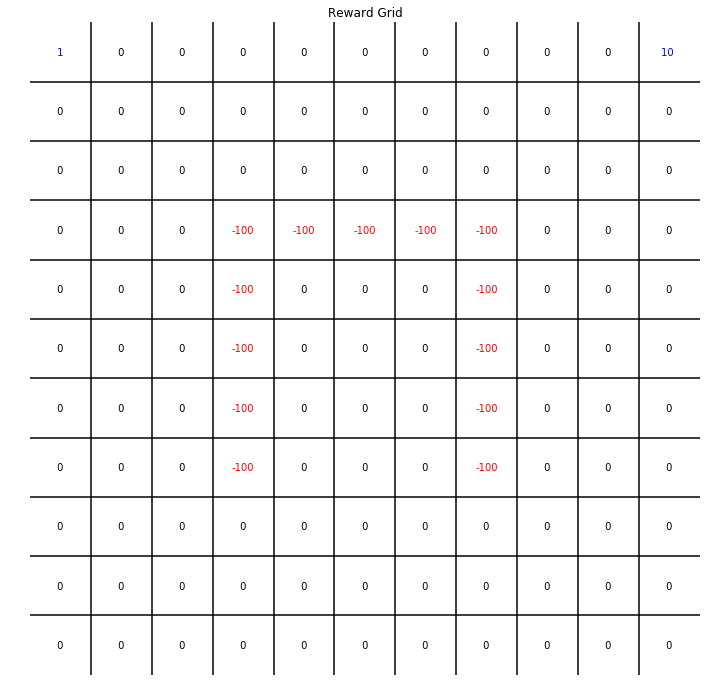

In [5]:
# Visualize the Reward Grid
R = get_nxn_rewardgrid(n=11)
plot_reward(R)

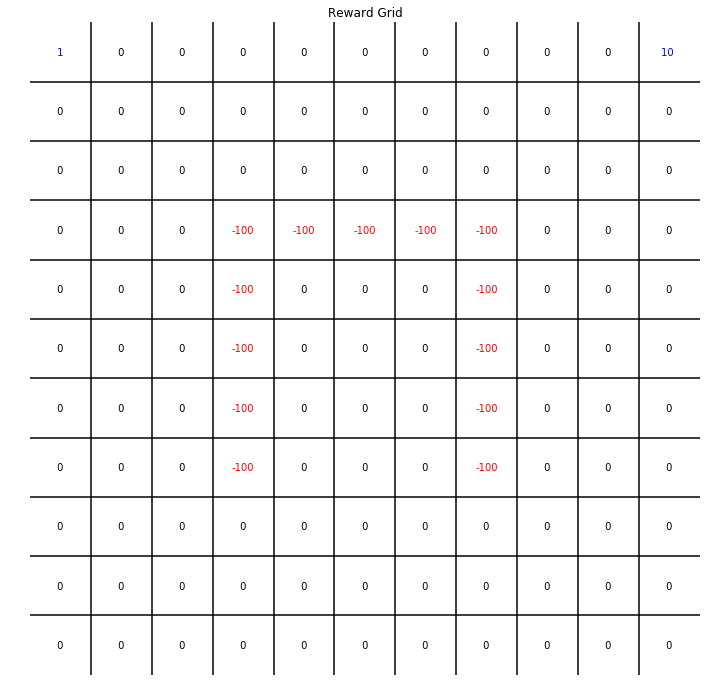

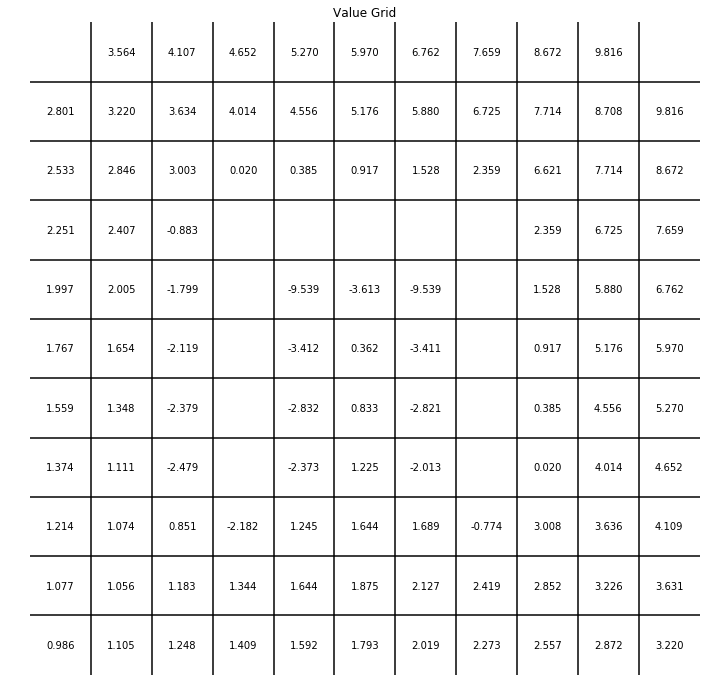

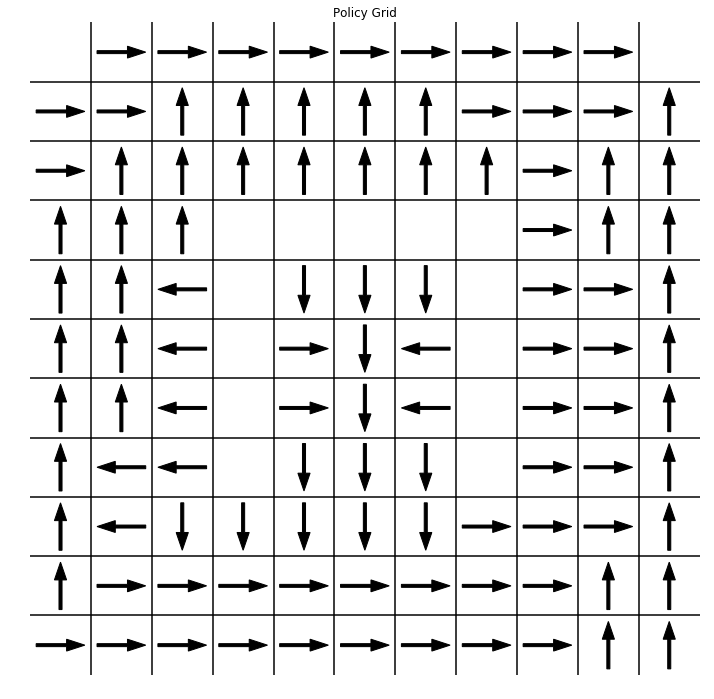

Value Iteration
Time Required: 0.1s
V[-1, 0] (Bottom Left):  0.98602179
V[-1,-1] (Bottom Right): 3.22033728


In [6]:
# TODO: Implement Value Iteration
# INSTRUCTIONS: Most of the required code has been provided for you. Place your 
#               code in the area indicated below.
# NOTE: You're free to modify this code as you wish, so long as your implimentation is correct, you'll receive full marks.
def value_iteration(R, p=0.9, discount_factor=0.9, debug=False, **kargs):
    assert type(R) == np.ndarray and R.shape[0] == R.shape[1]
    n, _ = R.shape
    
    # initialize value grid
    V  = np.zeros((n,n))
    V_ = V.copy()
    
    # transition probabilities
    T = p*np.identity(4) + ((1-p)/3)*(1-np.identity(4))
    # print(T)
    while True:
        # loop over all states
        for i in range(n):
            for j in range(n):
                # skip terminal states
                if R[i,j] != 0:
                    continue
                
                # given the current set of coordinates (i, j), return the set of 
                # next-state coordinates corresponding to all possible actions (UP, RIGHT, DOWN, LEFT)
                nextstate_coordinates = get_nextstate_coordinates(i, j, n)
                nextstate_rewards = np.array([R[ii,jj] for ii, jj in nextstate_coordinates])
                # print("rewards")
                # print(nextstate_rewards)
                nextstate_values  = np.array([V[ii,jj] for ii, jj in nextstate_coordinates])
                # print("values")
                # print(nextstate_values)

                ##### START OF YOUR CODE #####
                # Instructions: Implement the value iteration backup, placing the result in V_[i,j]
                # Note: To make things easier, we've extracted the next state rewards / next state values corresponding to
                #       to all possible actions (UP, RIGHT, DOWN, LEFT). See the 'nextstate_rewards' & 'nextstate_values'
                #       variables that we calculate for you above. You should understand how these are calculated.
                #       You are not required to use these if you perfer to extract these values yourself.
                # Hint: You may want to use of the following variables: nextstate_rewards, discount_factor, nextstate_values, T
                # Hint: You may find np.matmul and np.amax useful
                '''
                S:Set of states, n states
                A:Set of actions, m actions
                Ɣ: Discount factor, scalar
                R: reward function, n x m x n matrix(often independent of the action and past state)
                T: Transition function,n x m x n matrix 
                '''
                Q_temp = []
                # loop over actions
                for move in range(4):
                    Q_temp.append(nextstate_rewards[move]+discount_factor*nextstate_values[move])
                        
                    # print(discount_factor * sum_)
                Q = np.matmul(T,Q_temp)
                V_[i][j] = np.amax(Q)
                ##### END OF YOUR CODE #####
        
        delta = np.amax(np.abs(V_-V))
        V = V_.copy()
        
        if delta < 0.001:
            break
            
        if debug:
            plot_value(V, R, **kargs)
    
    # output a deterministic policy
    P = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            # skip terminal states
            if R[i,j] != 0:
                continue

            # given the current set of coordinates (i, j), return the set of 
            # next-state coordinates corresponding to all possible actions (UP, RIGHT, DOWN, LEFT)
            nextstate_coordinates = get_nextstate_coordinates(i, j, n)
            nextstate_rewards = np.array([R[ii,jj] for ii, jj in nextstate_coordinates])
            nextstate_values  = np.array([V[ii,jj] for ii, jj in nextstate_coordinates])

            ##### START OF YOUR CODE #####
            # Instructions: Determine the greedy policy based on V (that you calculated above), placing the result in P[i,j]
            # Hint: You may want to use of the following variables: nextstate_rewards, discount_factor, nextstate_values, T
            # Hint: You may find np.matmul and np.argmax useful

            # for all actions
            Q_temp = []
            # loop over actions
            for move in range(4):
                Q_temp.append(nextstate_rewards[move]+discount_factor*nextstate_values[move])
                    
                # print(discount_factor * sum_)
            Q = np.matmul(T,Q_temp)
            P[i][j] = np.argmax(Q)
            ##### END OF YOUR CODE #####
    
    return V, P


### Test Value Iteration Code (n=11, p=0.9, discount_factor=0.9)
R = get_nxn_rewardgrid(n=11)
plot_reward(R)

s_time = time.time()
V, P = value_iteration(R, p=0.9, discount_factor=0.9)
e_time = time.time()
plot_value(V, R)
plot_policy(P, R)

print('Value Iteration')
print('Time Required: {:^.2}s'.format(e_time-s_time))
print('V[-1, 0] (Bottom Left):  {:^10.8f}'.format(V[-1,0]))
print('V[-1,-1] (Bottom Right): {:^10.8f}'.format(V[-1,-1]))

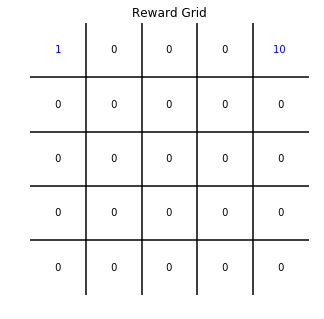

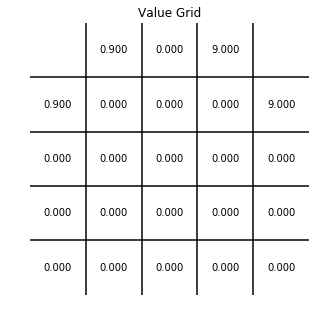

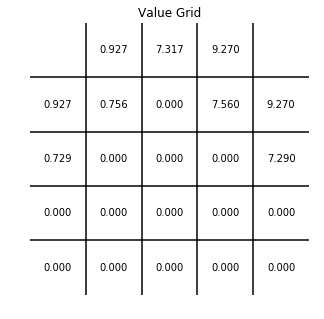

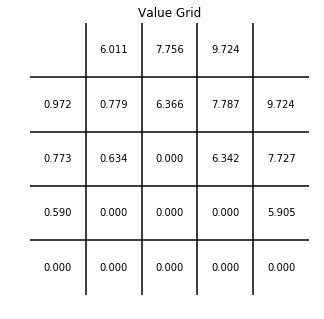

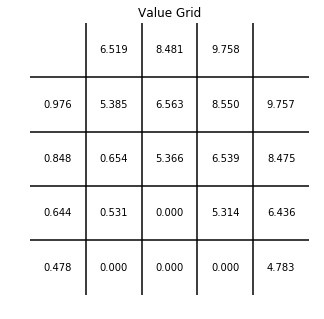

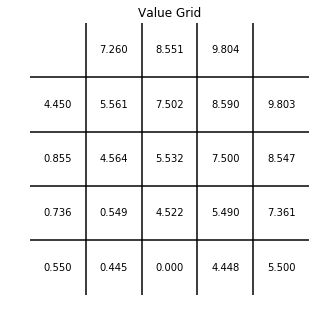

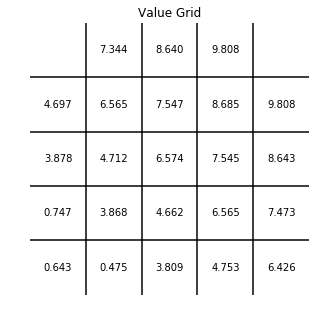

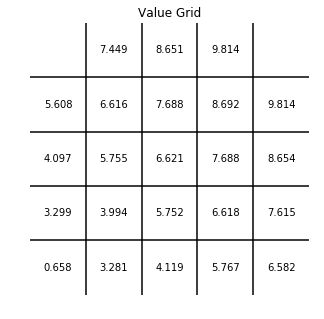

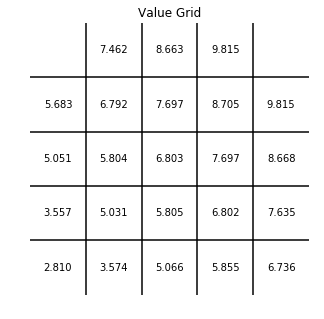

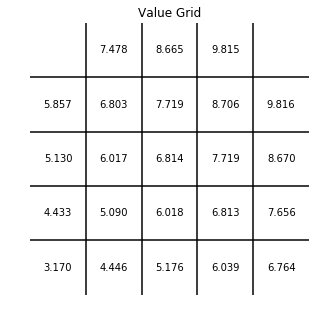

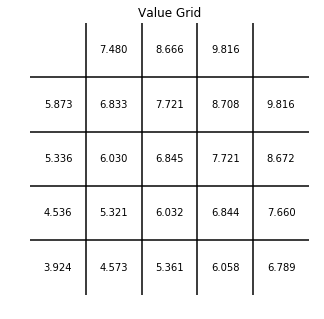

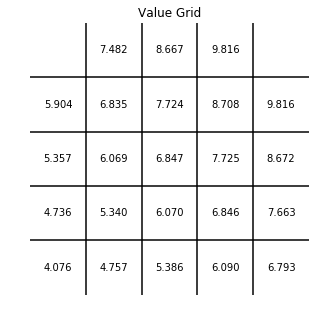

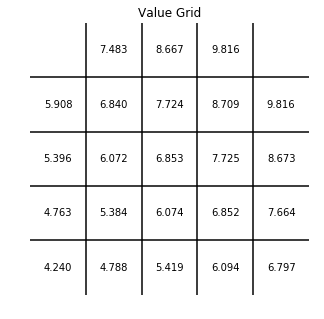

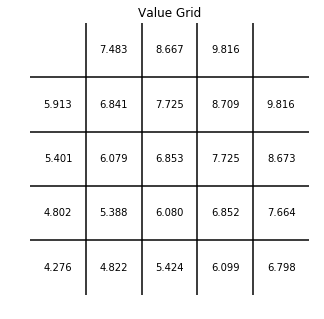

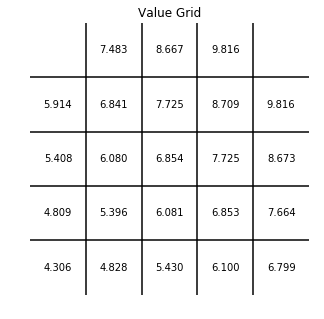

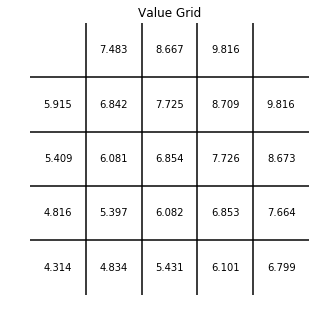

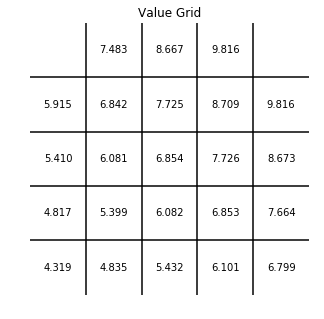

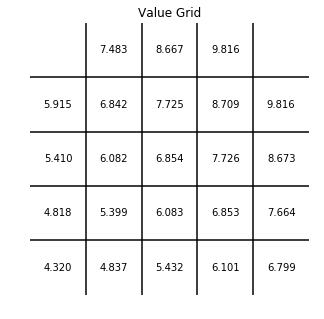

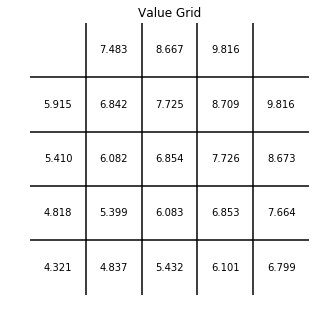

V[-1, 0] (Bottom Left):  4.32135151
V[-1,-1] (Bottom Right): 6.79919146


In [7]:
# TODO: Value Grid Propagation
# Instructions: It is important to understand how the value-iteration backup
#               propagates through the value grid. Here, we print off the value
#               grid after every backup. Comment on how the value grid evolves
#               over time.
R = get_nxn_rewardgrid(n=5, trap=False)
plot_reward(R, figsize=(5,5))

V, P = value_iteration(R, p=0.9, discount_factor=0.9, debug=True, figsize=(5,5))
plot_value(V, R, figsize=(5,5))

print('V[-1, 0] (Bottom Left):  {:^10.8f}'.format(V[-1,0]))
print('V[-1,-1] (Bottom Right): {:^10.8f}'.format(V[-1,-1]))

##### ANSWER BELOW #####
#

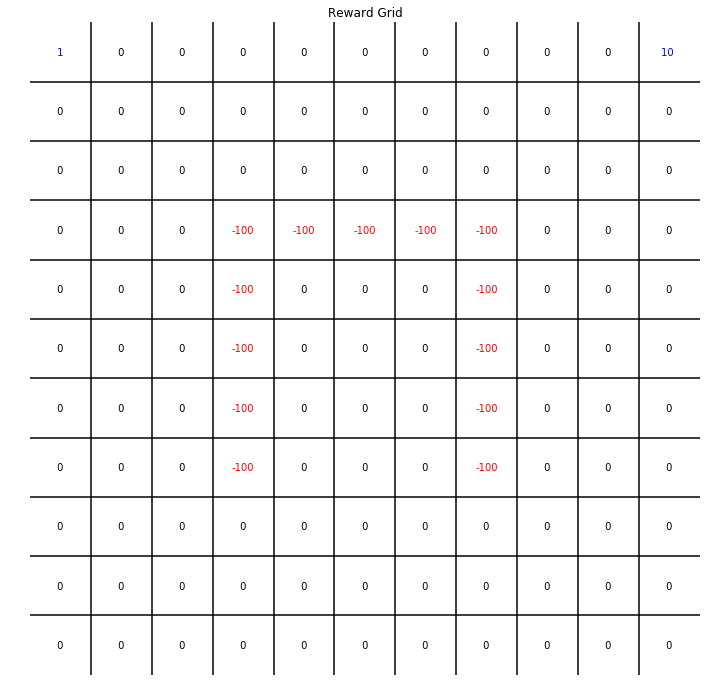

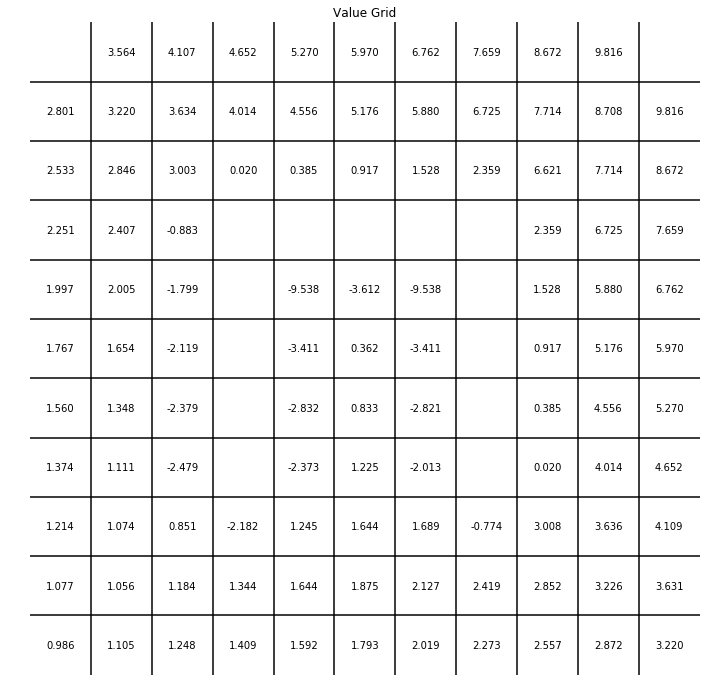

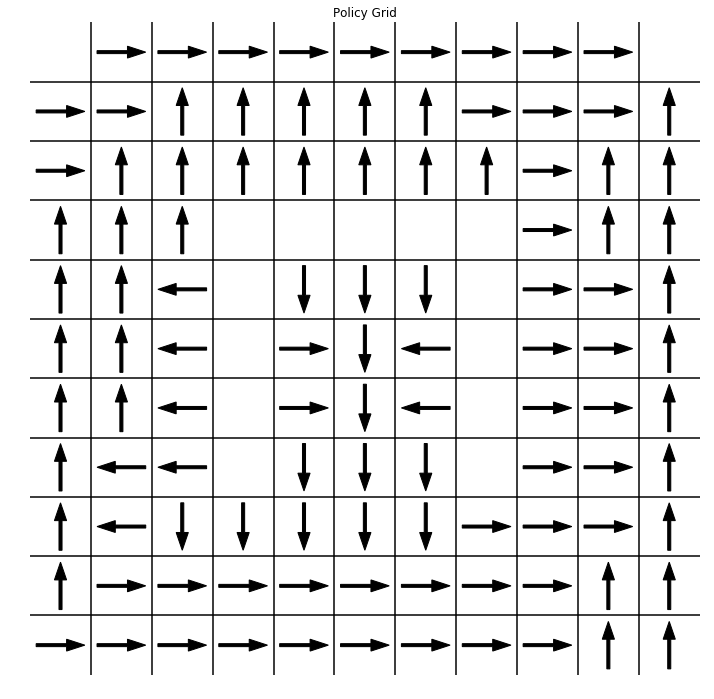

Policy Iteration
Time Required: 0.94s
V[-1, 0] (Bottom Left):  0.98645081
V[-1,-1] (Bottom Right): 3.22033742


In [25]:
# TODO: Implement Policy Iteration
# INSTRUCTIONS: Most of the required code has been provided for you. Place your 
#               code in the area indicated below.
# NOTE: You're free to modify this code as you wish, so long as your implimentation is correct, you'll receive full marks.
def policy_iteration(R, p=0.9, discount_factor=0.9):
    assert type(R) == np.ndarray and R.shape[0] == R.shape[1]
    n, _ = R.shape

    # initialize value grid
    V = np.zeros((n, n))
    V_ = V.copy()

    # initialize policy grid
    P = np.random.randint(0, 4, size=(n, n))

    # transition probabilities
    T = p * np.identity(4) + ((1 - p) / 3) * (1 - np.identity(4))
    while True:
        while True:   
            # loop over all states
            for i in range(n):
                for j in range(n):
                    # skip terminal states
                    if R[i, j] != 0:
                        continue

                    # given the current set of coordinates (i, j), return the set of 
                    # next-state coordinates corresponding to all possible actions (UP, RIGHT, DOWN, LEFT)
                    nextstate_coordinates = get_nextstate_coordinates(i, j, n)
                    nextstate_rewards = np.array([R[ii, jj] for ii, jj in nextstate_coordinates])
                    nextstate_values = np.array([V[ii, jj] for ii, jj in nextstate_coordinates])

                    ##### START OF YOUR CODE #####
                    # Instructions: Implement the policy iteration backup, placing the result in V_[i,j]
                    # Note: To make things easier, we've extracted the next state rewards / next state values corresponding to 
                    #       to all possible actions (UP, RIGHT, DOWN, LEFT). See the 'nextstate_rewards' & 'nextstate_values' 
                    #       variables that we calculate for you above. You should understand how these are calculated.
                    #       You are not required to use these if you perfer to extract these values yourself.
                    # Hint: You may want to use of the following variables: nextstate_rewards, discount_factor, nextstate_values, T
                    # Hint: You may find np.matmul useful
                    # Hint: Although very similar, the code here should NOT be identical to the corresponding section in value iteration (slightly different equations).
                    #v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
                    policy_a = P[i][j]
                    # 
                    Q_temp = []
                    for possible_action in range(4):
                        Q_temp.append(nextstate_rewards[possible_action]+discount_factor*nextstate_values[possible_action])
                    V_[i][j] = np.matmul(T[policy_a],Q_temp)

             
                    ##### END OF YOUR CODE #####

            delta = np.amax(np.abs(V_ - V))
            V = V_.copy()

            if delta < 0.001:
                break

        # loop over all states
        stable = True
        for i in range(n):
            for j in range(n):
                # skip terminal states
                if R[i, j] != 0:
                    continue

                # given the current set of coordinates (i, j), return the set of 
                # next-state coordinates corresponding to all possible actions (UP, RIGHT, DOWN, LEFT)
                nextstate_coordinates = get_nextstate_coordinates(i, j, n)
                nextstate_rewards = np.array([R[ii, jj] for ii, jj in nextstate_coordinates])
                nextstate_values = np.array([V[ii, jj] for ii, jj in nextstate_coordinates])

                ##### START OF YOUR CODE #####
                # Instructions: Determine the greedy policy based on V (that you calculated above), placing the result in P[i,j]
                #               You should update the 'stable' variable as required.
                # Hint: You may want to use of the following variables: nextstate_rewards, discount_factor, nextstate_values, T
                # Hint: You may find np.matmul and np.argmax useful
                # for all actions
                Q_temp = []
                # loop over actions
                for move in range(4):
                    Q_temp.append(nextstate_rewards[move]+discount_factor*nextstate_values[move])
                        
                    # print(discount_factor * sum_)
                Q = np.matmul(T,Q_temp)
                max = np.argmax(Q)
                if P[i][j] != max:
                    stable = False
                    P[i][j] = max
                
                ##### END OF YOUR CODE #####
        
        if stable:
            break
    return V, P


### Test Policy Iteration Code (n=11, p=0.9, discount_factor=0.9)
R = get_nxn_rewardgrid(n=11)
plot_reward(R)

s_time = time.time()
V, P = policy_iteration(R, p=0.9, discount_factor=0.9)
e_time = time.time()
plot_value(V, R)
plot_policy(P, R)

print('Policy Iteration')
print('Time Required: {:^.2}s'.format(e_time - s_time))
print('V[-1, 0] (Bottom Left):  {:^10.8f}'.format(V[-1, 0]))
print('V[-1,-1] (Bottom Right): {:^10.8f}'.format(V[-1, -1]))


In [26]:
# TODO: Compare Value Iteration and Policy Iteration
# Instructions: It is important to understand how value iteration and policy iteration
#               differ. To compare value iteration and policy iteration, inspect
#               the value of bottom left state as a function of n and p. Comment on
#               any differences you observe. Finally, compare the time requirements
#               of each algorithm (which one takes longer? why?).
for n in [11, 51]:
    for p in [0.7, 0.9]:
        ### Value Iteration
        print('Value Iteration (n={}, p={})'.format(n,p))
        R = get_nxn_rewardgrid(n=n)
        s_time = time.time()
        V, P = value_iteration(R, p=p, discount_factor=0.9)
        e_time = time.time()
        
        print('Time Required: {:^.2}s'.format(e_time-s_time))
        print('V[-1, 0] (Bottom Left):  {:^10.8f}'.format(V[-1,0]))
        print()

        ### Policy Iteration
        print('Policy Iteration (n={}, p={})'.format(n,p))
        R = get_nxn_rewardgrid(n=n)
        s_time = time.time()
        V, P = policy_iteration(R, p=p, discount_factor=0.9)
        e_time = time.time()
        
        print('Time Required: {:^.2}s'.format(e_time-s_time))
        print('V[-1, 0] (Bottom Left):  {:^10.8f}'.format(V[-1,0]))
        print()
        
##### ANSWER BELOW #####
#

Value Iteration (n=11, p=0.7)
Time Required: 0.19s
V[-1, 0] (Bottom Left):  0.02274691

Policy Iteration (n=11, p=0.7)


Time Required: 0.84s
V[-1, 0] (Bottom Left):  0.02457004

Value Iteration (n=11, p=0.9)
Time Required: 0.13s
V[-1, 0] (Bottom Left):  0.98602179

Policy Iteration (n=11, p=0.9)


Time Required: 0.73s
V[-1, 0] (Bottom Left):  0.98601173

Value Iteration (n=51, p=0.7)


Time Required: 4.2s
V[-1, 0] (Bottom Left):  0.00000769

Policy Iteration (n=51, p=0.7)


Time Required: 1.7e+01s
V[-1, 0] (Bottom Left):  0.00019688

Value Iteration (n=51, p=0.9)


Time Required: 4.7s
V[-1, 0] (Bottom Left):  0.00244497

Policy Iteration (n=51, p=0.9)


Time Required: 1.4e+01s
V[-1, 0] (Bottom Left):  0.00244704



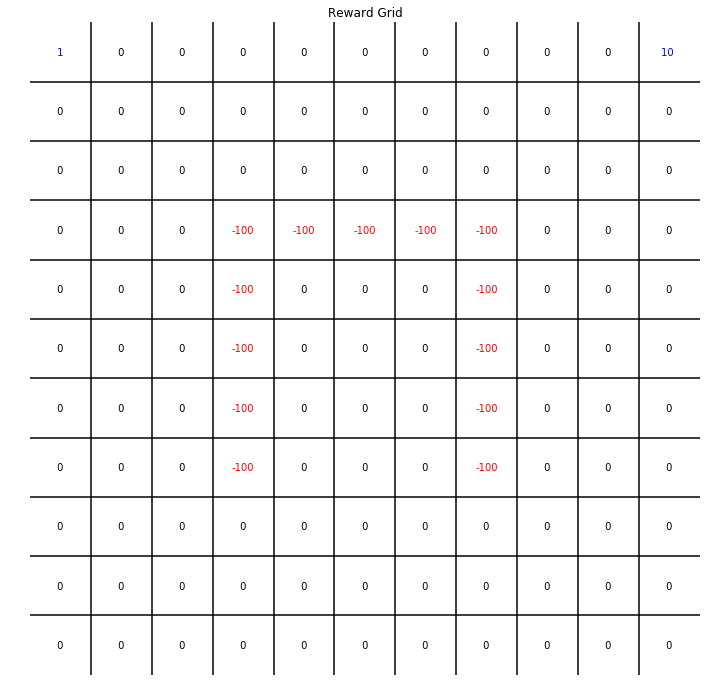

Policy Iteration (discount_factor=0.3)


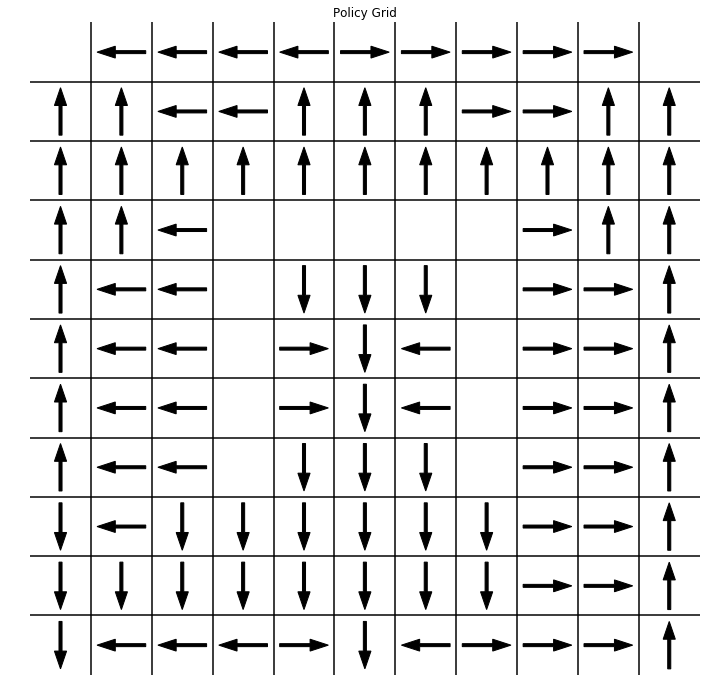


Policy Iteration (discount_factor=0.5)


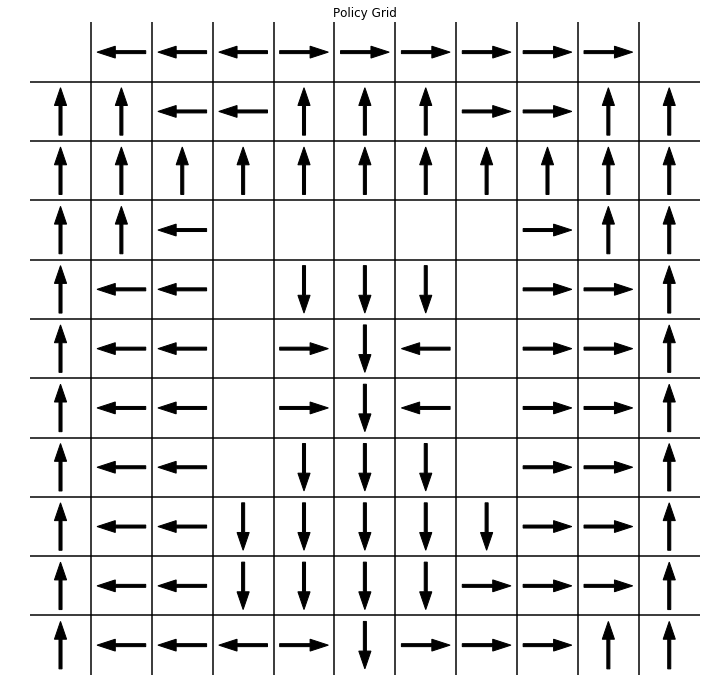


Policy Iteration (discount_factor=0.7)


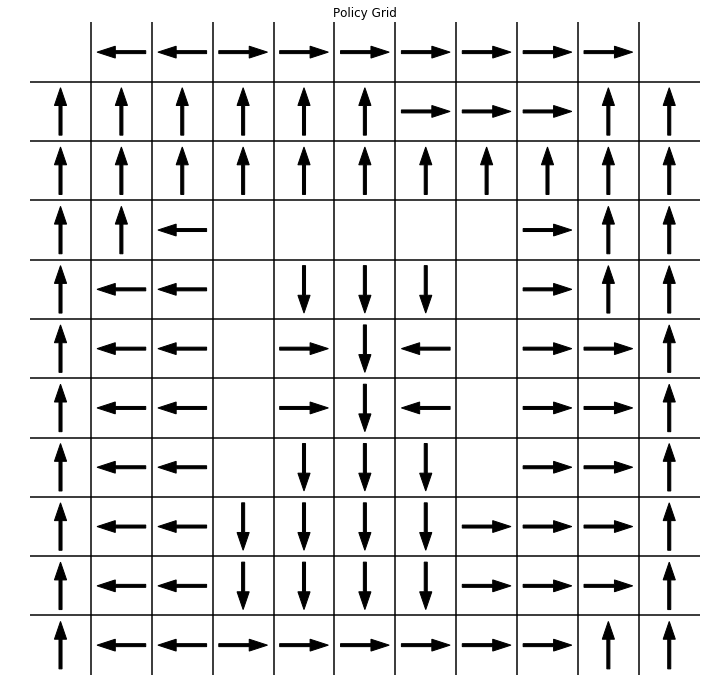


Policy Iteration (discount_factor=0.9)


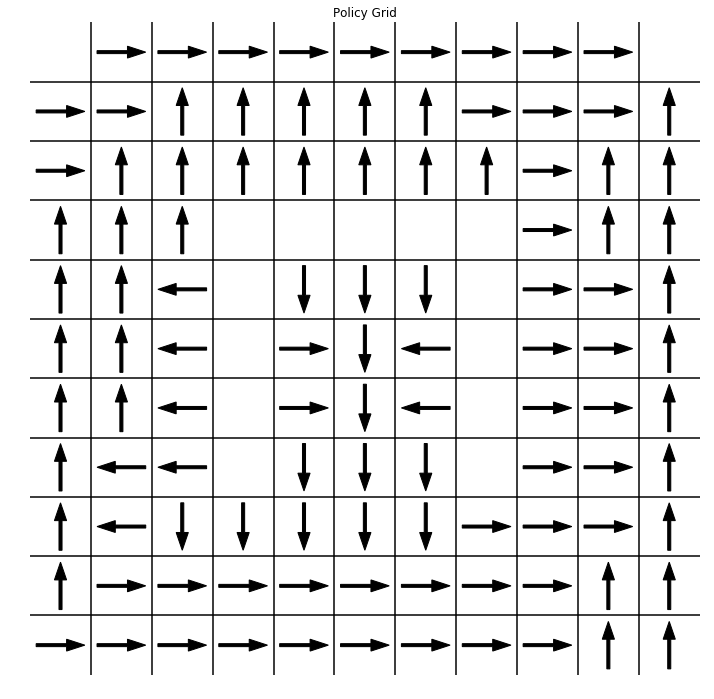

In [27]:
# TODO: Policy Iteration - Effect of the discount factor
# Instructions: It is important to understand how the discount factor effects the 
#               resulting policy. Analyize the policies produced as a function of 
#               the discount factor. How does the discount factor influence the 
#               policy? Relative to a small discount factor, does a large discount 
#               factor value short term or long term rewards more?
R = get_nxn_rewardgrid(n=11)
plot_reward(R)
for discount_factor in [0.3, 0.5, 0.7, 0.9]:
    print('Policy Iteration (discount_factor={})'.format(discount_factor))
    _, P = policy_iteration(R, p=0.9, discount_factor=discount_factor)
    plot_policy(P, R)
    print()

##### ANSWER BELOW #####
#